# Math 3910: Optimal Estimation and Control  |  LQR with Tracking Code
| Last update: May 18, 2022

| Katie Oliveras


## Important Updates (Please Read)
Please note the following: 
1. There was an error in the variational equations we derived in class.  Specifically, there was a minus sign mistake attached to $\vec{d}$.  It has been corrected in the following.  The variational equations shown below are correct.  
2. There was an error in the code when we solved for $\vec{p}_0$ and $\vec{x}_f$.  Specifically, the components on the right-hand side were "upside-down".  

These should be all of the major mistakes.  In this version of the code, I have set the tracking function to be 
$$\vec{d}(t) = \begin{bmatrix}\sin(t)\\\cos(t)\end{bmatrix}.$$

The graphs at the bottom also show how closely the output tracks our desired objective.  Try playing around with $\omega_1$ and $\omega_2$ to see what happens and report of the differences.  Explain why that happens.  


## Problem/Assignment Overview

Consider the following optimization problem: 

\begin{align*}
& \textsf{Minimize}\qquad && J[u,x] = \int_{t_0}^{t_f}\left[\frac{1}{2}(\vec{x}-\vec{d})^{\top} Q\, (\vec{x}-\vec{d}) + \frac{1}{2}\vec{u}^\top R\,\vec{u} \right]\,dt + \frac{1}{2}\left(\vec{x}-\vec{d}\right)^\top G \,(\vec{x}-\vec{d})\bigg\vert_{t = t_f}\\
& \textsf{Subject to} && \dot{\vec{x}} = A\vec{x} + B\vec{u},\\
& && \vec x(t_0) = \vec x_0,\\
&&& \textsf{where } t_0 \textsf{ and } t_f \textsf{ are known.}
\end{align*}

For this particular example, we have that $$\vec{d} = \begin{bmatrix}d_1(t)\\d_2(t)\end{bmatrix}$$ where $d_1(t)$ is the position we would like to track, and $d_2(t)$ is the velocity we would like to track.  

## Summary/Outline from Class
Following the problem as set-up in class, we have 
$$\tilde{J}[x,u,p] =\frac{1}{2}\int_{t_0}^{t_f}(\vec{x}-\vec{d})^{\top} Q\, (\vec{x}-\vec{d})+ \vec{u}^\top R\,\vec{u}   + \vec{p}^\top \left(A\vec{x} + B \vec{u} - \dot{\vec{x}}\right)\,dt + \frac{1}{2}(\vec{x}-\vec{d})^{\top} G\, (\vec{x}-\vec{d})\bigg\vert_{t = t_f}$$
where $\vec{p}$ represents our Lagrange multipliers.  Following the **Pontryagin's Principle Summary Handout**, and the work done in class, we have the following steps:


**Step 1:** In class, we found the following equations for the variations with respect to $u$, $\vec{x}$, $\vec{p}$
\begin{align*}
\delta u &: && 2 R u + B^\top \vec{p} = 0,\\
\delta \vec{x}&: && \dot{\vec{p}} = -2Q (\vec{x}-\vec{d}) - A^\top \vec{p},\\
\delta \vec{p}&: && \dot{\vec{x}} = A\vec{x} + B \vec{u},\\
\delta \vec{x}_f &: && \vec{p}\big\vert_{t_f} = 2 G \left(\vec{x} - \vec{d}(t)\right)\bigg\vert_{t_f},\\
\textsf{given}&:&& \vec{x}\big\vert_{t_0} = \vec{x}_0.
\end{align*}

**Step 2:** Since the optimal control is given by $\vec{u} = -\frac{1}{2}R^{-1}B^\top \vec{p}$, we can replace $\vec{u}$ in the above equations to express the above as a system of ODEs for the two unknowns $\vec{x}$ and $\vec{p}$ given by: 

$$\begin{bmatrix}\dot{\vec{x}}\\~\\\dot{\vec{ p}}\end{bmatrix} = \begin{bmatrix} A & -\frac{1}{2}BR^{-1}B^\top\\~\\-2Q^\top & -A^\top\end{bmatrix}\begin{bmatrix}\vec{x}\\~\\\vec{p}\end{bmatrix} + \begin{bmatrix}\vec{0}_{(2\times 1)}\\~\\2 Q^\top\vec{d}(t)\end{bmatrix}, \qquad \begin{bmatrix}\vec{x}(t_0)\\~\\\vec{p}(t_0)\end{bmatrix}=\begin{bmatrix}\vec{x}_0\\~\\\vec{p}_0\end{bmatrix}$$

**MINUS SIGN MISTAKE CORRECTED HERE**
The solution to the above system can be expressed in terms of the state-transition matrix $\Phi(t,t_0)$ as $$\begin{bmatrix}\vec{x}(t)\\\vec{p}(t)\end{bmatrix} = \Phi(t,t_0)\begin{bmatrix}\vec{x}_0\\\vec{p}_0\end{bmatrix} + \Phi(t,t_0)\int_{t_0}^{t}\Phi^{-1}(\sigma,t_0)\begin{bmatrix}\vec{0}\\2Q^\top\vec{d}(\sigma)\end{bmatrix}\,d\sigma,$$
where the challenge is that we don't have an initial condition for $\vec{p}$, nor do we know the value of $\vec{x}$ when $t = t_f$.  

**Step 3:** We can at least determine $\vec{x}_f$ via the $\delta \vec{x}_f$ variation to find that $$\vec{p} = 2G\left(\vec{x}_f - \vec{d}(t_f)\right).$$  Evaluating the solution to the system when $t = t_f$, we can relate the solution 

**Step 4:** Despite only knowing $\vec{x}_0$ and how $\vec{p}_f$ relates to $\vec{x}_f$, we can find the state transition matrix $\Phi(t,t_0)$.  The bulk of the document is about finding these matrices and thus the solution.


## The Code

### Preliminaries and Matrix Definitions

In [1]:
from matplotlib import pyplot as plt 
import numpy as np
plt.rcParams['text.usetex'] = False

Now, let's define the matrices $A$, $B$, $Q$, $R$, and $G$ where $$A = \begin{bmatrix}1 & 0\\0 & 0\end{bmatrix}, \qquad B = \begin{bmatrix}0\\1\end{bmatrix},\qquad Q = \begin{bmatrix}\omega_1& 0\\0 & \omega_2\end{bmatrix},\qquad R = \begin{bmatrix}1\end{bmatrix}, \qquad G = Q$$

For simplicity, I will initialize the $\omega_1$ and $\omega_2$ values to be $\omega_1 = 1$ and $\omega_2 = 1$.  You are welcome to play around with these values in order to see what happens.  

In [18]:
A = np.array([[0., 1.],[0., 0.]]);
B = np.array([[0.],[1.]]);

w1 = .5 # This is the relative importance we place on tracking the desired position d_1(t)
w2 = .5 # This is the relative importance we place on tracking the desired velocity d_2(t)

Q = np.array([[w1,0.],[0., w2]]);
R = np.array([[1.]]);

G = Q;


def d(t):
    return np.array([[np.sin(t)],[np.cos(t)]])


Let's also set the initial and final times, $t_0$ and $t_f$ respectively.  Finally, we can input the initial condition $x_0$.  

In [19]:
t0 = 0;
tf = 20;
x0 = np.array([[3.],[1.]])

At this point, we will now define the number of time-steps (`numSteps`), as well the vector of $t$ values at which we will compute the solution (`tV`), and the width of each time step (`dt`).  

In [20]:
numSteps = 201;
tV = np.linspace(t0,tf,numSteps);
dt = tV[1]-tV[0];



### Numerically Solving for the Transition Matrix $\Phi(t,t_0)$
Recall that the state transition matrix $\Phi(t,t_0)$ satisfies the differential equation 
$$\frac{d\Phi}{dt} = \underbrace{\begin{bmatrix}A & -\frac{1}{2}B R^{-1}B^\top\\-2Q^\top & -A^\top\end{bmatrix}}_{{K}}\Phi, \quad \Phi(t_0,t_0) = I.$$
We can use Euler's method to numerically integrate and time-step the solution for $\Phi$.  Recall that Euler's method says that $$\Phi(t_j + \Delta t,t_0) \approx \Phi(t_j,t_0) + \Delta t\cdot K \Phi(t_j,t_0) \approx (I + \Delta t\cdot K)\Phi(t_j,t_0)$$

In the following block of code, we initializes an array that will store $\Phi$ at each time step.  Now, we will take the prescribed number of steps (`numSteps`) to approximate the transition matrix $\Phi$ from $t_0$ to $t_f$. 

In the following loop, we also compute the value of $$\texttt{intTerm}(t) = \int_{t_0}^{t_f}\Phi^{-1}(\sigma,t_0)\begin{bmatrix}\vec{0}\\2 Q^\top \vec{d}(\sigma)\end{bmatrix}\,d\sigma$$ for each value of $t_j$.  

In [21]:
K = np.vstack((np.hstack((A, -1/2.*B@np.linalg.inv(R)@B.T)),np.hstack((-2*Q.T, -A.T))))

Phi = np.zeros((numSteps,4,4)); Phi[0,:,:] = np.eye(4);
intTerm = np.zeros((numSteps,4,1)); intTerm[0,:,:] = np.zeros((4,1))

for j in range(0,numSteps-1):
    t = tV[j];
    tempVec = np.vstack((np.zeros((2,1)),2*Q.T@d(t + dt)))
    Phi[j+1,:,:] = (np.eye(4) + dt*K)@Phi[j,:,:]
    intTerm[j+1,:,:] = intTerm[j,:,:] + dt*np.linalg.inv(Phi[j+1,:,:])@tempVec
# The following simply determines Phi(t_f,t_0) by taking the final computed value of Phi

PhiF = Phi[-1,:,:]
PhiF11 = PhiF[0:2,0:2];
PhiF12 = PhiF[0:2,2:4];
PhiF21 = PhiF[2:4,0:2];
PhiF22 = PhiF[2:4,2:4];

vF = PhiF@intTerm[-1,:,:];

### Finding $\vec{p}_0$ and $\vec{x}_f$ using $\Phi(t_f,t_0)$.  
Recall that in class, we set up the system 

$$\begin{bmatrix}\vec{x}_f\\\vec{p}_f\end{bmatrix} = \begin{bmatrix} \Phi_{1,1}(t_f,t_0) & \Phi_{1,2}(t_f,t_0)\\\Phi_{2,1}(t_f,t_0) & \Phi_{2,2}(t_f,t_0)\end{bmatrix}\begin{bmatrix}\vec{x}_0\\\vec{p}_0\end{bmatrix}  + \vec{v}_f \quad \textsf{where}\quad \vec{p}_f = 2 G(\vec{x_f}-\vec{d}(t_f)), \quad \vec{v}_f = \Phi(t_f,t_0)\int_{t_0}^{t_f} \Phi^{-1}(\sigma,t_0)\begin{bmatrix}\vec{0}\\2Q^\top\vec{d}(\sigma)\end{bmatrix}\,d\sigma.$$ 


Considering the unknowns to be $\vec{x}_f$ and $\vec{p}_0$, we can rearrange the system to find 

$$\underbrace{\begin{bmatrix}I & -\Phi_{1,2}(t_f,t_0)\\G & -\Phi_{2,2}(t_f,t_0)\end{bmatrix}}_{\textsf{{lhs}}}\begin{bmatrix}\vec{x}_f\\\vec{p}_0\end{bmatrix} = \underbrace{\begin{bmatrix}\Phi_{1,1}(t_f,t_0)\vec{x}_0\qquad \qquad ~~\\\Phi_{2,1}(t_f,t_0)\vec{x}_0 + 2 G \vec{d}(t_f)\end{bmatrix}+ \vec{v}_f}_{\textsf{{rhs}}}$$
which becomes
$$ \begin{bmatrix}\vec{x}_f\\\vec{p}_0\end{bmatrix} = \begin{bmatrix}I & -\Phi_{1,2}(t_f,t_0)\\G & -\Phi_{2,2}(t_f,t_0)\end{bmatrix}^{-1}\left(\begin{bmatrix}\Phi_{1,1}(t_f,t_0)\vec{x}_0 \qquad \qquad~~\\\Phi_{2,1}(t_f,t_0)\vec{x}_0 + 2 G \vec{d}(t_f)\end{bmatrix}+ \vec{v}_f\right)$$

Because computing inverses of matrices via commands such as `np.linalg.inv` are less preferred over using `np.linalg.solve`.  However, since the matrices involved are small, we will use `np.linalg.inv` to solve.  

In [22]:
lhs1 = np.hstack((np.eye(2),-PhiF12));
lhs2 = np.hstack((2*G,-PhiF22));
lhs = np.vstack((lhs1,lhs2));

################################################################
### PLEASE NOTE: There was an error here in terms of defining the right-hand-side of the equation.  
################################################################
rhs = np.vstack((PhiF11@x0, PhiF21@x0 + 2*G@d(tf))) + vF;

output = np.linalg.solve(lhs,rhs)

# peel off the last two terms as this represents the initial condition for p.
p0 = output[2:4];

# now, create the vector of initial conditions for z = [x  p]^T
z0 = np.vstack((x0,p0));


Now that we have the initial conditions $\vec{z}_0 = \left[\vec{x}_0~~\vec{p}_0\right]^\top$ and the state-transition matrix $\Phi(t,t_0)$ (computed for each time step), we can find $\vec{z}$ at each time step by noting that the solution to the problem is given by $$\vec{z}(t) = \Phi(t,t_0)\vec{z}_0 + \Phi(t,t_0)\int_{t_0}^t\Phi^{-1}(\sigma,t_0)\begin{bmatrix}0\\2 Q^\top \vec{d}(\sigma)\end{bmatrix}\,d\sigma\quad \textsf{and}\quad u(t) = -\frac{1}{2}R^{-1}B^\top\vec{p}(t)$$

In [23]:
z = np.zeros((numSteps,4,1))
u = np.zeros((numSteps))
dOut = np.zeros((numSteps,2,1)) # This is simply creating a vector of the desired trajectory values.

for j in range(0,numSteps):
    t = tV[j]
    z[j,:,:] = Phi[j,:,:]@(z0 + intTerm[j,:,:]); #computing the solution given by z(t) = Phi(t,t_0)*(z0 + intTerm)
    u[j] = -1/2.*np.linalg.inv(R)@B.T@z[j,2:4,:]; # computing the control law u(t) = -1/2*R^(-1)B^(T)*p(t)
    dOut[j,:,:] = d(t); #saving the trajectory values d(t) for comparison later on


### Plotting the Solution/Output

Now that we have computed the control, let's see what happens when we implement this.  

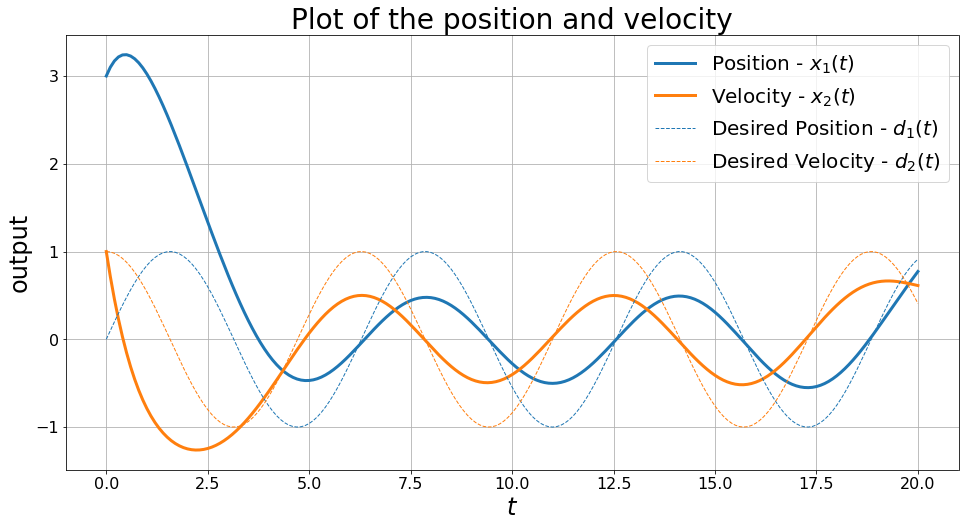

In [24]:
plt.figure(figsize=(16, 8))

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

# Plot the actual trajectories for the position and velocity
plt.plot(tV,z[:,0:2,:].reshape(numSteps,2),'-',linewidth=3)
         
# The following line restarts the color cycles so that the actual and desired trajectories have the same colors
plt.gca().set_prop_cycle(None) 

# Plot the desired trajectories for the position and velocity that comes out of d_1(t) and d_2(t).
plt.plot(tV,dOut[:,:,:].reshape(numSteps,2),'--',linewidth=1)

plt.legend([r'Position - $x_1(t)$','Velocity - $x_2(t)$','Desired Position - $d_1(t)$','Desired Velocity - $d_2(t)$'],fontsize=20)
plt.xlabel(r'$t$', fontsize=24)
plt.ylabel(r'output', fontsize=24)
plt.title(r'Plot of the position and velocity',fontsize=28)
plt.grid()
plt.show()


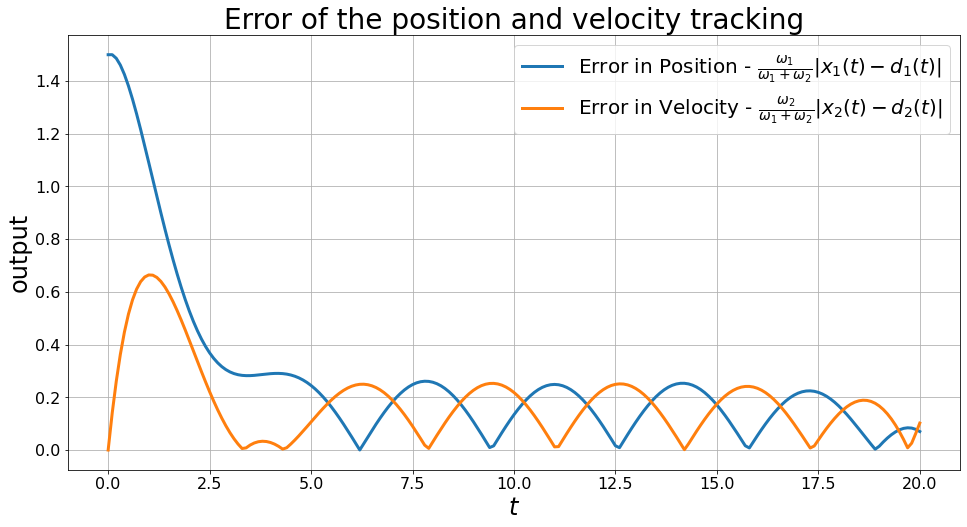

In [17]:
plt.figure(figsize=(16, 8))


plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.plot(tV,np.abs(np.array([[w1,w2]])*(z[:,0:2,:].reshape(numSteps,2)-dOut[:,:,:].reshape(numSteps,2))),'-',markersize=10,linewidth=3)
plt.legend([r'Error in Position - $\frac{\omega_1}{\omega_1+\omega_2}\vert x_1(t)-d_1(t)\vert $',r'Error in Velocity - $\frac{\omega_2}{\omega_1+\omega_2}\vert x_2(t)-d_2(t)\vert$'],fontsize=20)

plt.xlabel(r'$t$', fontsize=24)
plt.ylabel(r'output', fontsize=24)
plt.title(r'Error of the position and velocity tracking',fontsize=28)
plt.grid()
plt.show()


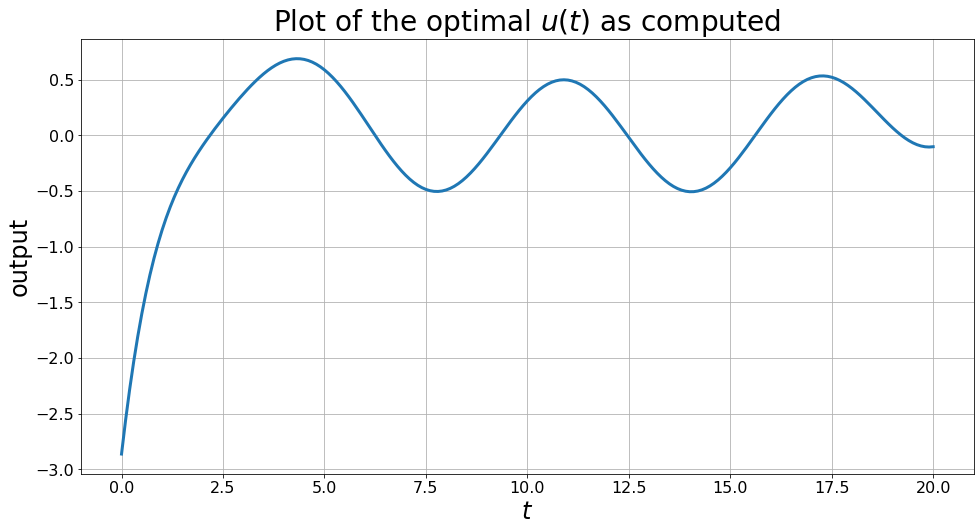

In [25]:
plt.figure(figsize=(16, 8))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.plot(tV,u,'-',linewidth=3)
plt.xlabel(r'$t$', fontsize=24)
plt.ylabel(r'output', fontsize=24)
plt.title(r'Plot of the optimal $u(t)$ as computed',fontsize=28)
plt.grid()
plt.show()
